# CNN
For taking in a 56x56 ball and determining if it's stripe, solid, or the aim circle

In [37]:
import project
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from pathlib import Path
from PIL import Image
import random

In [75]:
class BallDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.data = []
        self.labels = []
        self.augment = augment

        label_map = {'stripe': 0, 'solid': 1, 'aim_circle': 2}
        root_path = Path(root_dir)

        for label_name, label_value in label_map.items():
            folder_path = root_path / label_name
            for fpath in folder_path.iterdir():
                if fpath.is_file():
                    self.data.append(fpath)
                    self.labels.append(label_value)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()
        ]) if augment else transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_np = project.preprocess_file(str(self.data[idx]), size=56, padding=0, thresh_1=(0.5,1.1), thresh_2=(0.9,1.1), close_size=2, open_size=2)
        img = self.transform(img_np)
        return img, self.labels[idx]

# create train/val/test splits
base_dataset = BallDataset('labeling/', augment=False)
train_size = int(0.7 * len(base_dataset))
val_size = int(0.15 * len(base_dataset))
test_size = len(base_dataset) - train_size - val_size


train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(base_dataset)), [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = Subset(BallDataset('labeling/', augment=True), train_indices)
val_dataset   = Subset(BallDataset('labeling/', augment=False), val_indices)
test_dataset  = Subset(BallDataset('labeling/', augment=False), test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [ ]:
class BallCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(32 * 14 * 14, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

    def forward(self, x):
        return self.fc(self.conv(x))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = BallCNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


best_val_acc = 0.0
best_model_state = None
best_epoch = 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            predicted = preds.argmax(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_epoch = epoch + 1

print(f"\nBest model was from epoch {best_epoch} with Val Accuracy: {best_val_acc:.4f}")

model.load_state_dict(best_model_state)

Using device: cuda
Epoch 1, Train Loss: 18.2815, Val Accuracy: 0.7364
Epoch 2, Train Loss: 14.4008, Val Accuracy: 0.8062
Epoch 3, Train Loss: 11.6120, Val Accuracy: 0.7674
Epoch 4, Train Loss: 9.3245, Val Accuracy: 0.8372
Epoch 5, Train Loss: 7.6244, Val Accuracy: 0.8760
Epoch 6, Train Loss: 6.5538, Val Accuracy: 0.8992
Epoch 7, Train Loss: 5.9217, Val Accuracy: 0.9147
Epoch 8, Train Loss: 5.4584, Val Accuracy: 0.9147
Epoch 9, Train Loss: 5.0896, Val Accuracy: 0.9225
Epoch 10, Train Loss: 4.9489, Val Accuracy: 0.9302
Epoch 11, Train Loss: 4.8195, Val Accuracy: 0.9380
Epoch 12, Train Loss: 4.6189, Val Accuracy: 0.9457
Epoch 13, Train Loss: 4.5088, Val Accuracy: 0.9690
Epoch 14, Train Loss: 4.4842, Val Accuracy: 0.9380
Epoch 15, Train Loss: 4.5051, Val Accuracy: 0.9457
Epoch 16, Train Loss: 4.4142, Val Accuracy: 0.9535
Epoch 17, Train Loss: 4.2550, Val Accuracy: 0.9457
Epoch 18, Train Loss: 4.2409, Val Accuracy: 0.9457
Epoch 19, Train Loss: 4.0861, Val Accuracy: 0.9302
Epoch 20, Train Lo

<All keys matched successfully>

In [ ]:
# test accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        predicted = preds.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9077


In [79]:
# save model
torch.save(model.state_dict(), 'ball_type.pth')

Class probabilities:
        stripe: 0.9815
         solid: 0.0002
    aim_circle: 0.0183


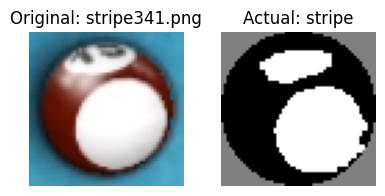

Class probabilities:
        stripe: 0.9207
         solid: 0.0379
    aim_circle: 0.0414


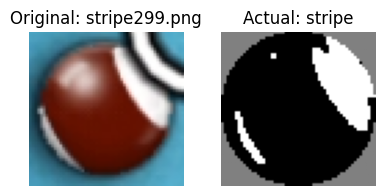

Class probabilities:
        stripe: 0.9916
         solid: 0.0011
    aim_circle: 0.0073


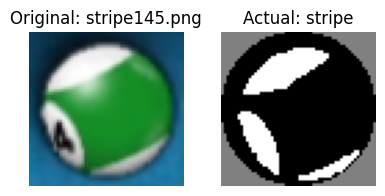

Class probabilities:
        stripe: 0.0251
         solid: 0.9723
    aim_circle: 0.0026


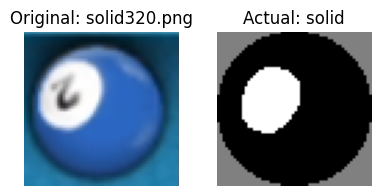

Class probabilities:
        stripe: 0.5482
         solid: 0.4343
    aim_circle: 0.0175


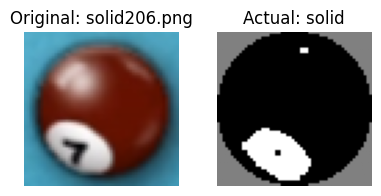

Class probabilities:
        stripe: 0.0305
         solid: 0.9673
    aim_circle: 0.0022


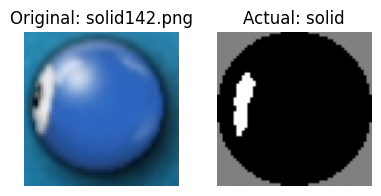

Class probabilities:
        stripe: 0.0734
         solid: 0.0000
    aim_circle: 0.9266


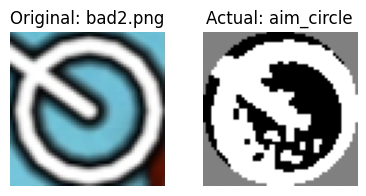

Class probabilities:
        stripe: 0.6326
         solid: 0.0000
    aim_circle: 0.3674


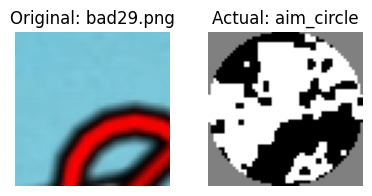

Class probabilities:
        stripe: 0.0783
         solid: 0.0000
    aim_circle: 0.9217


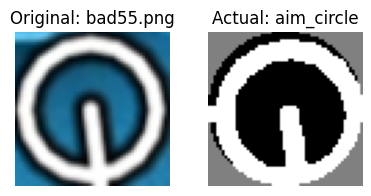

In [81]:
# manually test a few images from each class
label_names = ['stripe', 'solid', 'aim_circle']


def test_image(model, image_path, show=True):
    model.eval()
    actual_label = Path(image_path).parent.name
    original_img = Image.open(image_path) 
    img_np = project.preprocess_file(image_path, size=56, padding=0,
                                     thresh_1=(0.5, 1.1), thresh_2=(0.9, 1.1),
                                     close_size=2, open_size=2)
    img = torch.tensor(img_np).unsqueeze(0).unsqueeze(0).float().to(device)  # shape: (1, 1, 56, 56)

    with torch.no_grad():
        logits = model(img)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    print("Class probabilities:")
    for i, prob in enumerate(probs):
        print(f"  {label_names[i]:>12}: {prob:.4f}")

    if show:
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))
        axs[0].imshow(original_img, cmap='gray')
        axs[0].set_title(f"Original: {image_path.split('/')[-1]}")
        axs[0].axis('off')

        axs[1].imshow(img_np, cmap='gray')
        axs[1].set_title(f"Actual: {actual_label}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

for class_name in label_names:
    folder = Path('labeling') / class_name
    files = list(folder.glob("*.png"))
    sample_files = random.sample(files, min(3, len(files)))
    for f in sample_files:
        test_image(model, str(f), show=True)
